In [1]:
import torch
from utils import blogm, bSqc, Neg, Sa


def depolarizing(rho, eps=0.1):
    I = torch.eye(rho.shape[-1], rho.shape[-1], dtype=rho.dtype, device=rho.device)[None,...].expand(rho.shape[0], -1, -1)/rho.shape[-1]
    return (1-eps)*rho + eps*I

In [2]:
H = (torch.tensor([[1,1],[1,-1]])/2**0.5).to(torch.cdouble)
H.conj().T@H


tensor([[1.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 1.0000+0.j]], dtype=torch.complex128)

In [3]:
u = torch.tensor([[torch.tensor(-1j*torch.pi/4).exp()/torch.sqrt(torch.tensor(2)),torch.tensor(1j*torch.pi/4).exp()/torch.sqrt(torch.tensor(2))],
                  [0,0],
                  [0,0],
                  [torch.tensor(1j*torch.pi/4).exp()/torch.sqrt(torch.tensor(2)),torch.tensor(-1j*torch.pi/4).exp()/torch.sqrt(torch.tensor(2))]]).view(2,2,2).to(torch.cdouble)
v = torch.tensor([[0,0,0,2**0.5],[2**0.5,0,0,0]]).view(2,2,2).to(torch.cdouble)
torch.einsum(u, [1,2,3], v, [3,4,5], [1,4,2,5]).reshape(4,4)
v = v.permute(1,2,0)

In [4]:
theta = torch.rand(1)*torch.pi/2
phi = torch.rand(1)*torch.pi
U = torch.tensor([[torch.cos(theta/2)*torch.exp(1.0j*phi/2),torch.sin(theta/2)*torch.exp(-1.0j*phi/2)],
                          [-torch.sin(theta/2)*torch.exp(1.0j*phi/2),torch.cos(theta/2)*torch.exp(-1.0j*phi/2)]])

U.T.conj()@U

tensor([[1.0000e+00+4.6848e-09j, 1.2651e-09+1.7220e-08j],
        [1.2651e-09+2.0412e-08j, 1.0000e+00-2.4820e-09j]])

In [5]:
def cross(m, theta, phi, kernel):
    U = torch.tensor([[torch.cos(theta/2)*torch.exp(1.0j*phi/2),torch.sin(theta/2)*torch.exp(-1.0j*phi/2)],
                          [-torch.sin(theta/2)*torch.exp(1.0j*phi/2),torch.cos(theta/2)*torch.exp(-1.0j*phi/2)]], dtype=kernel.dtype)
    out = H@torch.tensor([1,0], dtype=kernel.dtype)
    out = torch.einsum(kernel, [0,1,2],
                       out, [0],
                       [1,2])
    out = torch.einsum(kernel, [1,3,4],
                       out, [1,2],
                       [2,3,4])
    out = torch.einsum(kernel, [3,5,6],
                       out, [2,3,4],
                       [2,4,5,6])
    out = torch.einsum(kernel, [5,7,8],
                       out, [2,4,5,6],
                       [7,8,6,4,2])
    # single qubit rotation
    out = torch.einsum(U, [9,7],
                       out, [7,8,6,4,2],
                       [9,8,6,4,2])
    if m == 0:
        m = torch.tensor([1,0], dtype=u.dtype)
    elif m == 1:
        m = torch.tensor([0,1], dtype=u.dtype)
    if m is not None:
        out = torch.einsum(m, [9],
                        out, [9,8,6,4,2],
                        [8,6,4,2])
    return out

def side(m, theta, phi, kernel):
    U = torch.tensor([[torch.cos(theta/2)*torch.exp(1.0j*phi/2),torch.sin(theta/2)*torch.exp(-1.0j*phi/2)],
                          [-torch.sin(theta/2)*torch.exp(1.0j*phi/2),torch.cos(theta/2)*torch.exp(-1.0j*phi/2)]], dtype=kernel.dtype)
    out = H@torch.tensor([1,0], dtype=kernel.dtype)
    out = torch.einsum(kernel, [0,1,2],
                       out, [0],
                       [1,2])
    out = torch.einsum(kernel, [1,3,4],
                       out, [1,2],
                       [2,3,4])
    out = torch.einsum(kernel, [3,5,6],
                       out, [2,3,4],
                       [2,4,5,6])
    # single qubit rotation
    out = torch.einsum(U, [7,5],
                       out, [2,4,5,6],
                       [7,6,4,2])
    if m == 0:
        m = torch.tensor([1,0], dtype=u.dtype)
    elif m == 1:
        m = torch.tensor([0,1], dtype=u.dtype)
    if m is not None: # (phy, bond, bond, bond)
        out = torch.einsum(m, [7],
                        out, [7,6,4,2],
                        [6,4,2])
    return out

def corner(m, theta, phi, kernel):
    U = torch.tensor([[torch.cos(theta/2)*torch.exp(1.0j*phi/2),torch.sin(theta/2)*torch.exp(-1.0j*phi/2)],
                          [-torch.sin(theta/2)*torch.exp(1.0j*phi/2),torch.cos(theta/2)*torch.exp(-1.0j*phi/2)]], dtype=kernel.dtype)
    out = H@torch.tensor([1,0], dtype=kernel.dtype)
    out = torch.einsum(kernel, [0,1,2],
                       out, [0],
                       [1,2])
    out = torch.einsum(kernel, [1,3,4],
                       out, [1,2],
                       [2,3,4])
    # single qubit rotation
    out = torch.einsum(U, [5,3],
                       out, [2,3,4],
                       [5,2,4])
    if m == 0:
        m = torch.tensor([1,0], dtype=u.dtype)
    elif m == 1:
        m = torch.tensor([0,1], dtype=u.dtype)
    if m is not None:
        out = torch.einsum(m, [5],
                        out, [5,2,4],
                        [2,4])
    return out

def contract(src, src_idx, dst, dst_idx):
    out_idx = src_idx.copy()
    for i in dst_idx:
        if i != 0: # batch dim
            if i in out_idx:
                out_idx.remove(i)
            else:
                out_idx.append(i)
    if 0 not in out_idx:
        out_idx = [0] + out_idx
    out_tensor = torch.einsum(src, src_idx,
                              dst, dst_idx,
                              out_idx)
    return out_tensor, out_idx

In [6]:
decode_N_values = []
decode_S_values = []
decode_I_values = []
d = 5
eps_values = [0.0,0.1,0.2,0.3,0.4,0.5]
for theta_idx in range(11):
    prep = torch.load(f'data/test_data/test_data_d={d}/prepseq_theta={theta_idx}.pt')
    rhoS = torch.load(f'data/test_data/test_data_d={d}/rhoS_theta={theta_idx}.pt')

    print(f'theta_idx={theta_idx} start prep_shape={prep.shape}')

    theta = torch.linspace(0, torch.pi/2, 11)[theta_idx]
    phi = torch.tensor((5/4)*torch.pi)

    u_cross = torch.cat([cross(0, theta, phi, u)[None,...], cross(1, theta, phi, u)[None,...]], dim=0)
    u_side = torch.cat([side(0, theta, phi, u)[None,...], side(1, theta, phi, u)[None,...]], dim=0)
    u_corner = torch.cat([corner(0, theta, phi, u)[None,...], corner(1, theta, phi, u)[None,...]], dim=0)
    v_cross = torch.cat([cross(0, theta, phi, v)[None,...], cross(1, theta, phi, v)[None,...]], dim=0)
    v_side = torch.cat([side(0, theta, phi, v)[None,...], side(1, theta, phi, v)[None,...]], dim=0)
    v_corner = torch.cat([corner(0, theta, phi, v)[None,...], corner(1, theta, phi, v)[None,...]], dim=0)
    # sixth row
    src, src_idx = contract(v_corner[prep[:,33]], [0,28,33],
            u_side[prep[:,32]], [0,32,33,26])
    src, src_idx = contract(src, src_idx,
                            v_side[prep[:,31]], [0,24,31,32])
    src, src_idx = contract(src, src_idx,
                            u_side[prep[:,30]], [0,22,30,31])
    src, src_idx = contract(src, src_idx,
                            v_side[prep[:,29]], [0,20,29,30])
    src, src_idx = contract(src, src_idx,
                            u_corner[prep[:,28]], [0,19,29])
    #print(src.shape, src_idx)
    # fifth row
    src, src_idx = contract(src, src_idx,
                            u_side[prep[:,27]], [0,17,27,28])
    src, src_idx = contract(src, src_idx,
                            v_cross[prep[:,26]], [0,15,25,26,27])
    src, src_idx = contract(src, src_idx,
                            u_cross[prep[:,25]], [0,13,23,24,25])
    src, src_idx = contract(src, src_idx,
                            v_cross[prep[:,24]], [0,11,21,22,23])
    src, src_idx = contract(src, src_idx,
                            u_cross[prep[:,23]], [0,9,18,20,21])
    src, src_idx = contract(src, src_idx,
                            v_side[prep[:,22]], [0,8,18,19])
    #print(src.shape, src_idx)
    # fourth row
    src, src_idx = contract(src, src_idx,
                            v_side[prep[:,21]], [0,6,16,17])
    src, src_idx = contract(src, src_idx,
                            u_cross[prep[:,20]], [0,5,14,15,16])
    src, src_idx = contract(src, src_idx,
                            v_cross[prep[:,19]], [0,4,12,13,14])
    src, src_idx = contract(src, src_idx,
                            u_cross[prep[:,18]], [0,3,10,11,12])
    src, src_idx = contract(src, src_idx,
                            v_cross[prep[:,17]], [0,2,7,9,10])
    src, src_idx = contract(src, src_idx,
                            u_side[prep[:,16]], [0,1,7,8])
    #print(src.shape, src_idx)
    # third row labeling [0,6,5,4,3,2,1]->[0,34,32,30,28,26,24]
    src, src_idx = contract(src, [0,34,32,30,28,26,24],
                            u_side[prep[:,15]], [0,23,33,34])
    src, src_idx = contract(src, src_idx,
                            v_cross[prep[:,14]], [0,21,31,32,33])
    src, src_idx = contract(src, src_idx,
                            u_cross[prep[:,13]], [0,19,29,30,31])
    src, src_idx = contract(src, src_idx,
                            v_cross[prep[:,12]], [0,17,27,28,29])
    src, src_idx = contract(src, src_idx,
                            u_cross[prep[:,11]], [0,15,25,26,27])
    src, src_idx = contract(src, src_idx,
                            v_side[prep[:,10]], [0,13,24,25])
    #print(src.shape, src_idx)
    # second row
    src, src_idx = contract(src, src_idx,
                            v_side[prep[:,9]], [0,11,22,23])
    src, src_idx = contract(src, src_idx,
                            u_cross[prep[:,8]], [0,9,20,21,22])
    src, src_idx = contract(src, src_idx,
                            v_cross[prep[:,7]], [0,7,18,19,20])
    src, src_idx = contract(src, src_idx,
                            u_cross[prep[:,6]], [0,5,16,17,18])
    src, src_idx = contract(src, src_idx,
                            v_cross[prep[:,5]], [0,3,14,15,16])
    src, src_idx = contract(src, src_idx,
                            u_side[prep[:,4]], [0,1,13,14])
    #print(src.shape, src_idx)
    # first row
    src, src_idx = contract(src, src_idx,
                            u_corner[prep[:,3]], [0,10,11])
    src, src_idx = contract(src, src_idx,
                            side(None, theta, phi, v), [41,8,9,10])
    src, src_idx = contract(src, src_idx,
                            u_side[prep[:,2]], [0,6,7,8])
    src, src_idx = contract(src, src_idx,
                            v_side[prep[:,1]], [0,4,5,6])
    src, src_idx = contract(src, src_idx,
                            u_side[prep[:,0]], [0,2,3,4])
    src, src_idx = contract(src, src_idx,
                            corner(None, theta, phi, v), [40,1,2])
    src = src.permute(0,2,1).contiguous()
    #print(src.shape, src_idx)
    rho = torch.vmap(torch.outer)(src.view(-1, 4), src.view(-1, 4).conj())
    coef = torch.vmap(torch.trace)(rho).view(-1,1,1)
    idx = (coef.real!=0).view(-1)
    rho = rho[idx]
    coef = coef[idx]
    rhoS = rhoS[idx]
    rho /= coef
    for eps in eps_values:
        decode_N_values.append(Neg(rhoS, depolarizing(rho, eps)))
        decode_S_values.append(bSqc(rhoS, depolarizing(rho, eps)))
        decode_I_values.append(Sa(rhoS, depolarizing(rho, eps))-bSqc(rhoS, depolarizing(rho, eps)))
        print(f'theta_idx={theta_idx} eps={eps} done', decode_N_values[-1].mean().item(), decode_S_values[-1].mean().item(), decode_I_values[-1].mean().item())
torch.save(torch.cat(decode_N_values).view(11,len(eps_values),-1), 'decode_N_values_d={d}.pt')
torch.save(torch.cat(decode_S_values).view(11,len(eps_values),-1), 'decode_S_values_d={d}.pt')
torch.save(torch.cat(decode_I_values).view(11,len(eps_values),-1), 'decode_I_values_d={d}.pt')

theta_idx=0 start prep_shape=torch.Size([1000000, 34])
theta_idx=0 eps=0.0 done -0.023074643527628887 1.9579332248092287 -1.0338259503947234
theta_idx=0 eps=0.1 done 0.0 0.26895418266934795 -0.1455043450195398
theta_idx=0 eps=0.2 done 0.0 0.30114352442030445 -0.14193773249992164
theta_idx=0 eps=0.3 done 0.0 0.37289039124666573 -0.16786325662680565
theta_idx=0 eps=0.4 done 0.0 0.4531974922487144 -0.1960813540511832
theta_idx=0 eps=0.5 done 0.0 0.5514626653811288 -0.23685795479806968
theta_idx=1 start prep_shape=torch.Size([1000000, 34])
theta_idx=1 eps=0.0 done -0.017697506747967127 1.5888407683143029 -1.3800755262347166
theta_idx=1 eps=0.1 done 0.0 0.22315648303327826 -0.12289836049078894
theta_idx=1 eps=0.2 done 0.0 0.2836913430937495 -0.1417908753911032
theta_idx=1 eps=0.3 done 0.0 0.3503303685625315 -0.15896440048160235
theta_idx=1 eps=0.4 done 0.0 0.4355163440881618 -0.18931784708991625
theta_idx=1 eps=0.5 done 0.0 0.5387080831516061 -0.23275511799852777
theta_idx=2 start prep_shap

In [8]:
torch.load(f'decode_N_values_d={d}.pt').shape

torch.Size([11, 6, 1000000])

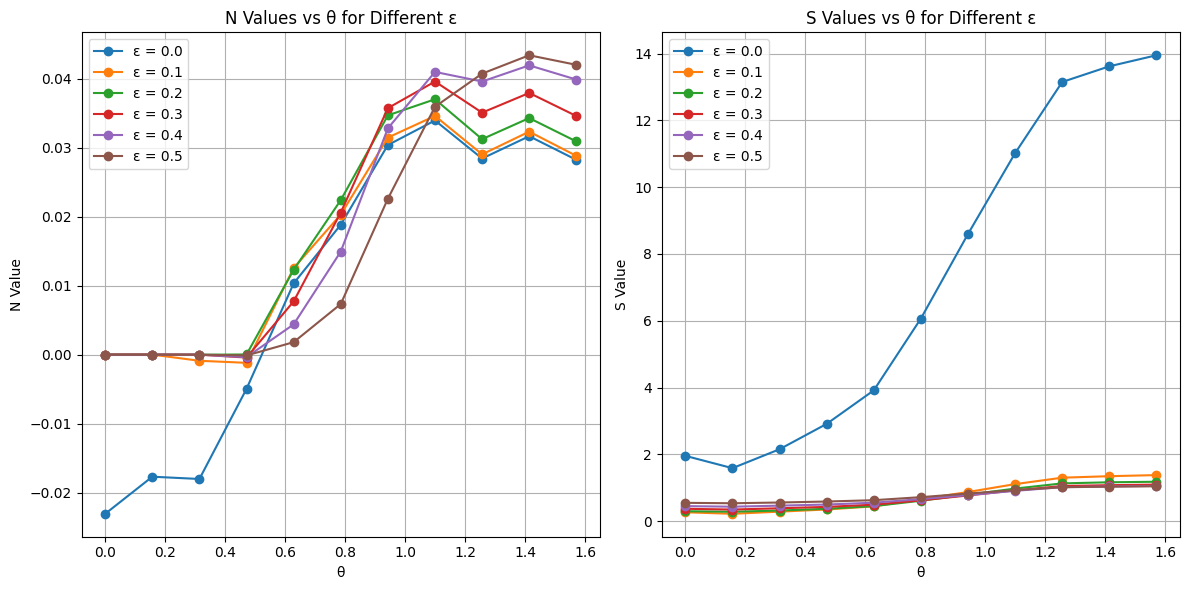

In [15]:
import matplotlib.pyplot as plt
import torch

# Load the saved data
N_values = torch.load('decode_N_values_eps.pt')
S_values = torch.load('decode_S_values_eps.pt')

# Create theta values for x-axis
theta_values = torch.linspace(0, torch.pi/2, 11)
eps_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot N values
plt.subplot(1, 2, 1)
for i, eps in enumerate(eps_values):
    plt.plot(theta_values, N_values[:, i].mean(dim=-1), 
             marker='o', label=f'ε = {eps}')
plt.xlabel('θ')
plt.ylabel('N Value')
plt.title('N Values vs θ for Different ε')
plt.grid(True)
plt.legend()

# Plot S values
plt.subplot(1, 2, 2)
for i, eps in enumerate(eps_values):
    plt.plot(theta_values, S_values[:, i].mean(dim=-1), 
             marker='o', label=f'ε = {eps}')
plt.xlabel('θ')
plt.ylabel('S Value')
plt.title('S Values vs θ for Different ε')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

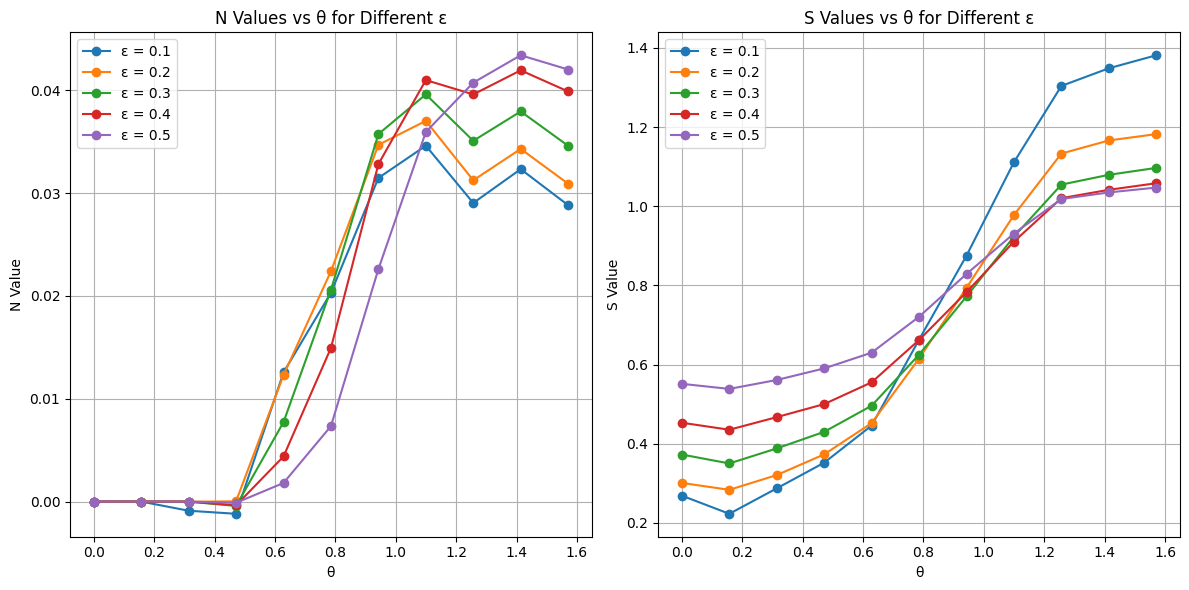

In [16]:
import matplotlib.pyplot as plt
import torch

# Load the saved data
N_values = torch.load('decode_N_values_eps.pt')
S_values = torch.load('decode_S_values_eps.pt')

# Create theta values for x-axis
theta_values = torch.linspace(0, torch.pi/2, 11)
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5]  # Removed 0.0

# Create the plot
plt.figure(figsize=(12, 6))

# Plot N values
plt.subplot(1, 2, 1)
for i, eps in enumerate(eps_values):
    plt.plot(theta_values, N_values[:, i+1].mean(dim=-1),  # Note: i+1 to skip first column
             marker='o', label=f'ε = {eps}')
plt.xlabel('θ')
plt.ylabel('N Value')
plt.title('N Values vs θ for Different ε')
plt.grid(True)
plt.legend()

# Plot S values
plt.subplot(1, 2, 2)
for i, eps in enumerate(eps_values):
    plt.plot(theta_values, S_values[:, i+1].mean(dim=-1),  # Note: i+1 to skip first column
             marker='o', label=f'ε = {eps}')
plt.xlabel('θ')
plt.ylabel('S Value')
plt.title('S Values vs θ for Different ε')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
torch.load('../../../figure_source/2d_figure/gpt_S_values_d=5.pt', map_location=torch.device('cpu')).shape

torch.Size([11, 1000000])

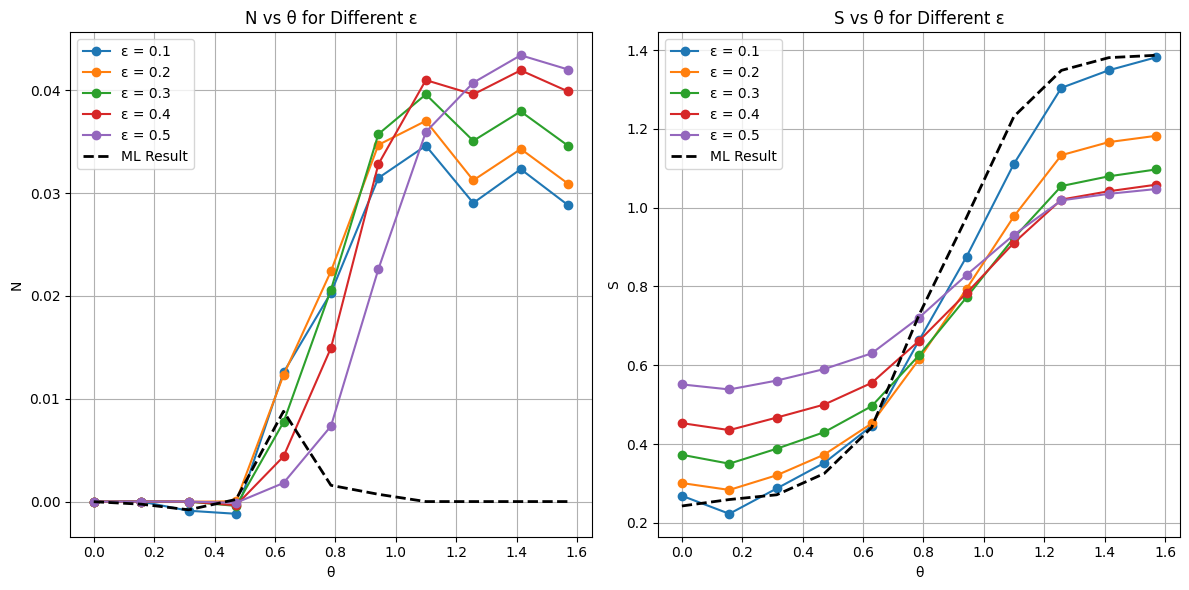

In [22]:
import matplotlib.pyplot as plt
import torch

# Load the saved data
N_values = torch.load('decode_N_values_eps.pt')
S_values = torch.load('decode_S_values_eps.pt')

# Load ML results
ml_N_values = torch.load('../../../figure_source/2d_figure/gpt_N_values_d=5.pt', map_location=torch.device('cpu'))
ml_S_values = torch.load('../../../figure_source/2d_figure/gpt_S_values_d=5.pt', map_location=torch.device('cpu'))

# Create theta values for x-axis
theta_values = torch.linspace(0, torch.pi/2, 11)
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot N values
plt.subplot(1, 2, 1)
# Plot depolarization results
for i, eps in enumerate(eps_values):
    plt.plot(theta_values, N_values[:, i+1].mean(dim=-1), 
             marker='o', label=f'ε = {eps}')
# Plot ML results
plt.plot(theta_values, ml_N_values.mean(dim=-1), 
         'k--', linewidth=2, label='ML Result')
plt.xlabel('θ')
plt.ylabel('N')
plt.title('N vs θ for Different ε')
plt.grid(True)
plt.legend()

# Plot S values
plt.subplot(1, 2, 2)
# Plot depolarization results
for i, eps in enumerate(eps_values):
    plt.plot(theta_values, S_values[:, i+1].mean(dim=-1), 
             marker='o', label=f'ε = {eps}')
# Plot ML results
plt.plot(theta_values, ml_S_values.mean(dim=-1), 
         'k--', linewidth=2, label='ML Result')
plt.xlabel('θ')
plt.ylabel('S')
plt.title('S vs θ for Different ε')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()